In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import json

In [95]:
df_charging = pd.read_pickle("data/charging_modified.pkl")
df_exploration = df_charging.set_index('connectionTime')

### 1) Hourly Sum of Time without Charging

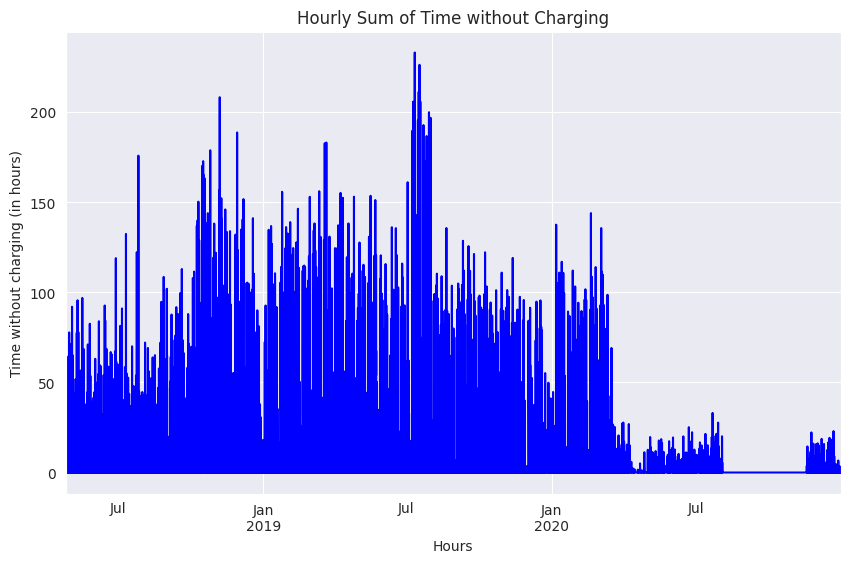

In [96]:
# Plot the hourly sum of time without charging
exploration_hourly = df_exploration['NoChargingTimeHours'].resample('H').sum()
plt.figure(figsize=(10, 6))
#plt.plot(df_charging['kWhDelivered'], linestyle='-', color='b')
exploration_hourly.plot(kind='line', linestyle='-', color='b')
#plt.plot(df_charging.index, df_charging['kWhDelivered'])
plt.title('Hourly Sum of Time without Charging')
plt.xlabel('Hours')
plt.ylabel('Time without charging (in hours)')
plt.grid(True)
plt.show()

In [97]:
df_exploration['NoChargingTimeHours'].resample('H').sum()

connectionTime
2018-04-25 13:00:00+00:00    16.417222
2018-04-25 14:00:00+00:00    24.501389
2018-04-25 15:00:00+00:00    79.513611
2018-04-25 16:00:00+00:00    23.122222
2018-04-25 17:00:00+00:00     6.821667
                               ...    
2020-12-31 14:00:00+00:00     0.000000
2020-12-31 15:00:00+00:00     0.000000
2020-12-31 16:00:00+00:00     0.001389
2020-12-31 17:00:00+00:00     0.000000
2020-12-31 18:00:00+00:00     0.058333
Freq: H, Name: NoChargingTimeHours, Length: 23550, dtype: float64

### 2) Hourly Sum of Charging Time

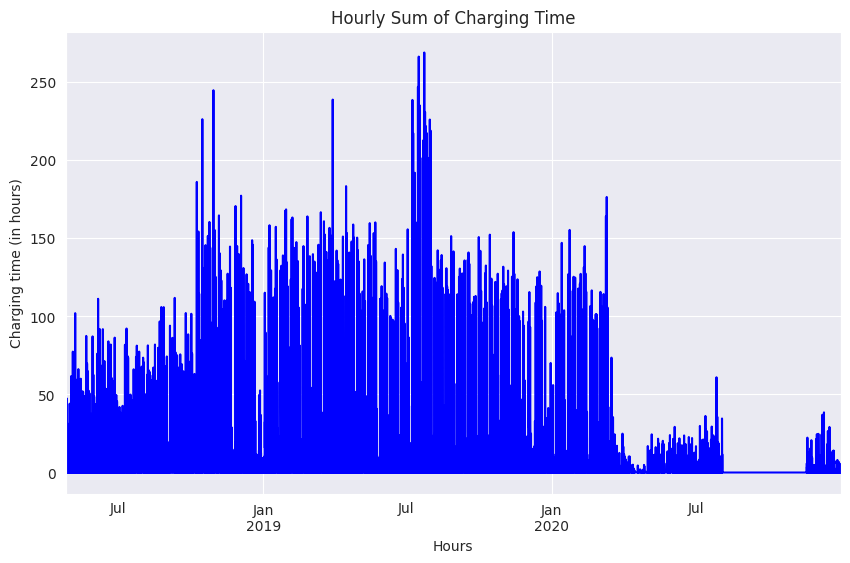

In [98]:
# Plot the hourly sum of charging time
exploration_hourly = df_exploration['ChargingTimeHours'].resample('H').sum()
plt.figure(figsize=(10, 6))
#plt.plot(df_charging['kWhDelivered'], linestyle='-', color='b')
exploration_hourly.plot(kind='line', linestyle='-', color='b')
#plt.plot(df_charging.index, df_charging['kWhDelivered'])
plt.title('Hourly Sum of Charging Time')
plt.xlabel('Hours')
plt.ylabel('Charging time (in hours)')
plt.grid(True)
plt.show()

In [99]:
df_exploration['ChargingTimeHours'].resample('H').sum()

connectionTime
2018-04-25 13:00:00+00:00     4.083056
2018-04-25 14:00:00+00:00    11.548333
2018-04-25 15:00:00+00:00    31.389444
2018-04-25 16:00:00+00:00    34.324722
2018-04-25 17:00:00+00:00     2.254167
                               ...    
2020-12-31 14:00:00+00:00     0.000000
2020-12-31 15:00:00+00:00     0.000000
2020-12-31 16:00:00+00:00     0.761111
2020-12-31 17:00:00+00:00     0.000000
2020-12-31 18:00:00+00:00     3.382222
Freq: H, Name: ChargingTimeHours, Length: 23550, dtype: float64

### 3) Hourly Sum of kWh Delivered

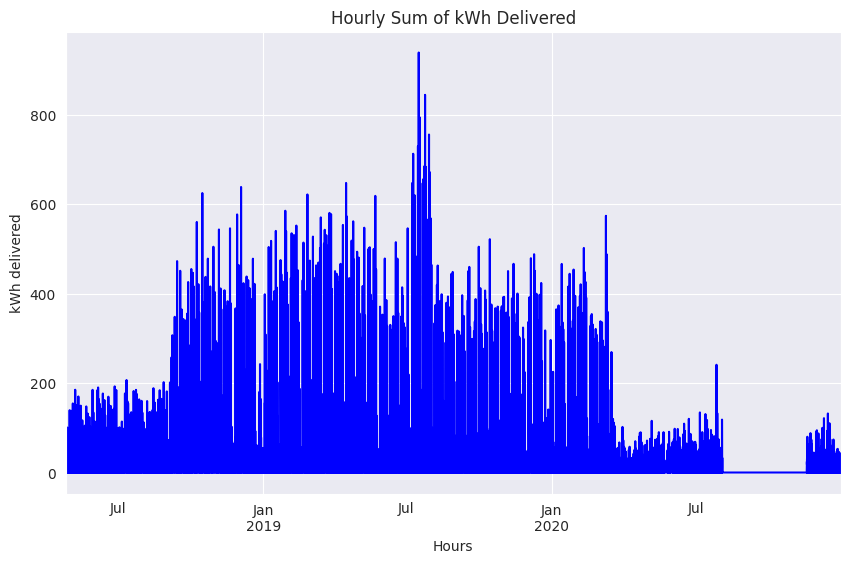

In [100]:
# Plot the hourly sum of kWh delivered
exploration_hourly = df_exploration['kWhDelivered'].resample('H').sum()
plt.figure(figsize=(10, 6))
#plt.plot(df_charging['kWhDelivered'], linestyle='-', color='b')
exploration_hourly.plot(kind='line', linestyle='-', color='b')
#plt.plot(df_charging.index, df_charging['kWhDelivered'])
plt.title('Hourly Sum of kWh Delivered')
plt.xlabel('Hours')
plt.ylabel('kWh delivered')
plt.grid(True)
plt.show()

In [101]:
df_exploration['kWhDelivered'].resample('H').sum()

connectionTime
2018-04-25 13:00:00+00:00    15.270
2018-04-25 14:00:00+00:00    45.453
2018-04-25 15:00:00+00:00    67.066
2018-04-25 16:00:00+00:00    98.398
2018-04-25 17:00:00+00:00     5.070
                              ...  
2020-12-31 14:00:00+00:00     0.000
2020-12-31 15:00:00+00:00     0.000
2020-12-31 16:00:00+00:00    30.192
2020-12-31 17:00:00+00:00    20.526
2020-12-31 18:00:00+00:00    10.571
Freq: H, Name: kWhDelivered, Length: 23550, dtype: float64

### 4) Utilization Rate per Site per Hours

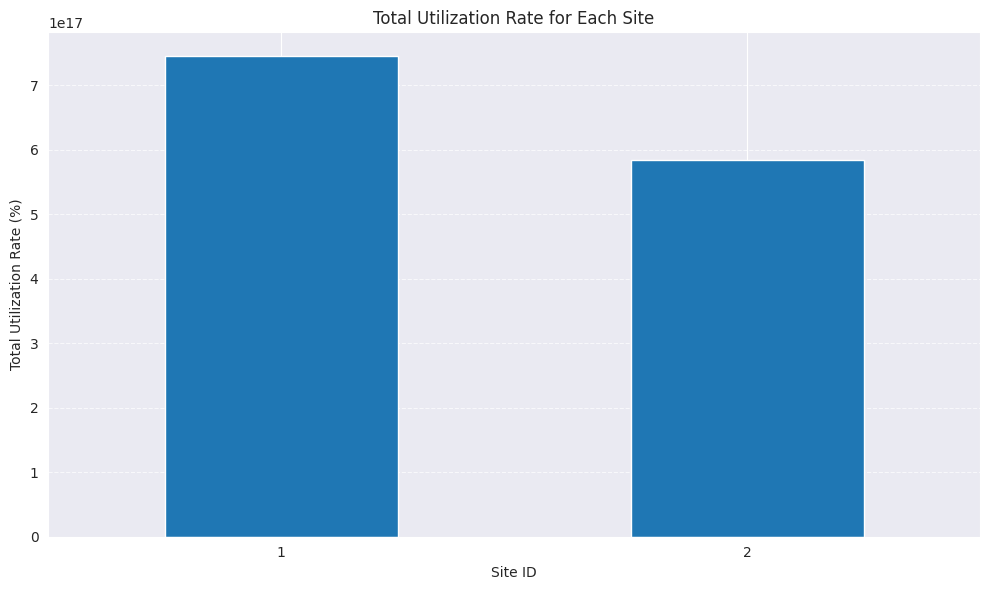

In [102]:
# Total charging time for each station
total_charging_time_per_station = 2 * 24  # 2 possibilities * 24 hours 

# Calculate total operational hours for each station
df_charging['TotalOperationalHours'] = (df_charging['disconnectTime'] - df_charging['connectionTime']).dt.total_seconds() / 3600

# Calculate utilization rate for each station
df_charging['UtilizationRate'] = (df_charging['ChargingTime'] / total_charging_time_per_station) * 100

# Group by siteID and calculate total utilization rate for each site
total_utilization_rate_per_site = df_charging.groupby('siteID')['UtilizationRate'].sum()

# Plot the total utilization rate for each site
plt.figure(figsize=(10, 6))
total_utilization_rate_per_site.plot(kind='bar')
plt.title('Total Utilization Rate for Each Site')
plt.xlabel('Site ID')
plt.ylabel('Total Utilization Rate (%)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


34565     0
34566     1
34567     1
34568     3
34569     3
         ..
34713    23
34714    23
34715    23
34716    23
34717    23
Name: Hour, Length: 153, dtype: int32
Hour  siteID
0     2            75.850000
1     2           146.583333
3     1           220.166667
4     2           207.916667
5     2           476.033333
12    1          2045.666667
13    1         11065.666667
14    1         11850.000000
      2           228.016667
15    2          2024.466667
16    2          2496.316667
17    2           248.783333
18    2           645.216667
19    1           717.166667
20    1           326.733333
      2           300.766667
21    1          1103.066667
      2           182.350000
22    1          1193.366667
23    1           147.466667
      2           160.233333
Name: ChargingTime, dtype: float64
6000
Hour  siteID
0     2           1.264167
1     2           2.443056
3     1           3.669444
4     2           3.465278
5     2           7.933889
12    1          34.

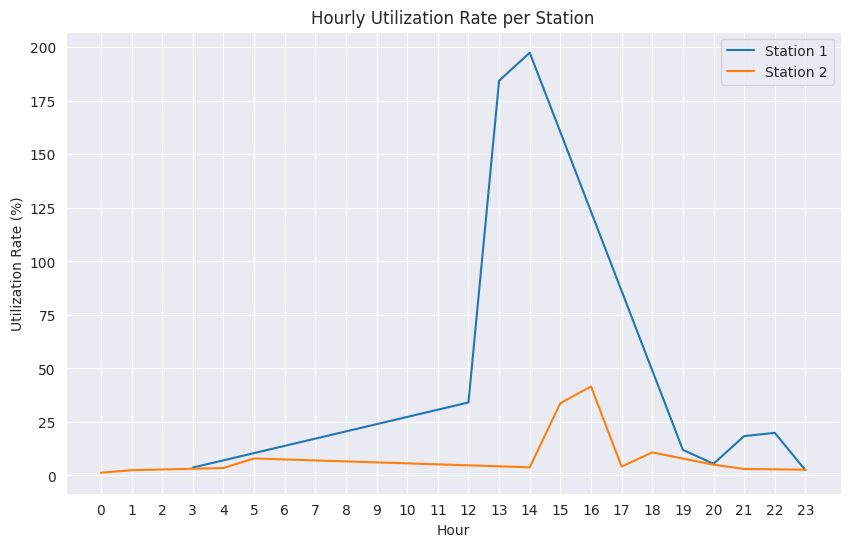

In [103]:
import pandas as pd
import matplotlib.pyplot as plt

# Specify the day you want to visualize (e.g., "2019-07-18")
specific_day = "2019-07-18"

# Convert specific_day to datetime
specific_day = pd.to_datetime(specific_day).date()

# Filter data for the specific day
df_specific_day = df_charging[pd.to_datetime(df_charging['connectionTime']).dt.date == specific_day].copy()  # Make a copy

# Check if there is any data available for the specific day
if df_specific_day.empty:
    print(f"No data available for {specific_day}")
else:
    # Calculate the hour of the connection time
    df_specific_day['Hour'] = df_specific_day['connectionTime'].dt.hour
    print(df_specific_day['Hour'])
    # Calculate the charging duration in each hour for each station
    hourly_charging_duration_per_station = df_specific_day.groupby(['Hour', 'siteID'])['ChargingTime'].sum()

    # Calculate the total possible charging time per station in each hour
    #total_possible_charging_time_per_station = (2*50) # 2 possibilities per station
    # Calculate the total possible charging time per station in each hour
    total_possible_charging_time_per_station = 120 * 50 # 120 Minuten
    total_seconds = hourly_charging_duration_per_station.dt.total_seconds()

    # Convert total seconds to minutes
    total_minutes = total_seconds / 60  # 60 seconds in a minute
    # Calculate the utilization rate for each station in each hour
    # hourly_utilization_rate_per_station = (hourly_charging_duration_per_station / total_possible_charging_time_per_station) * 100
    # Calculate the utilization rate for each station in each hour
    hourly_utilization_rate_per_station = (total_minutes / total_possible_charging_time_per_station) *100  # 24 Stunden * 60 Minuten

    # Convert total seconds to minutes
    print(total_minutes)
    print(total_possible_charging_time_per_station)
    print(hourly_utilization_rate_per_station)

# Plot the utilization rate per station and hour
plt.figure(figsize=(10, 6))

# Iterate over each station
for station_id, data in hourly_utilization_rate_per_station.groupby(level='siteID'):
    plt.plot(data.index.get_level_values('Hour'), data.values, label=f'Station {station_id}')

plt.title('Hourly Utilization Rate per Station')
plt.xlabel('Hour')
plt.ylabel('Utilization Rate (%)')
plt.xticks(range(24))  # Set ticks for each hour
plt.legend()
plt.grid(True)
plt.show()


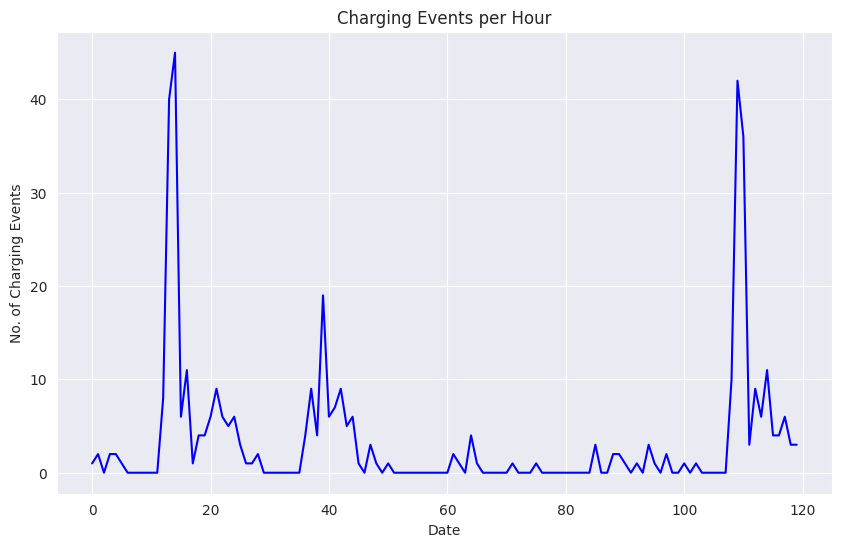

In [104]:
filtered_df = df_exploration.loc['2019-07-18': '2019-07-22']
filtered_df = filtered_df.resample('H')['id'].count().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['id'], linestyle='-', color='b')
plt.title('Charging Events per Hour')
plt.xlabel('Date')
plt.ylabel('No. of Charging Events')
plt.grid(True)
plt.show()

### 5) Utilization Rate per Station per Hour

,year,month,day,hour,minute,siteID,count,utilisation_rate
0,2019,7,21,3,45,2,1,1.818182
1,2019,7,21,13,15,1,2,3.846154
2,2019,7,21,13,27,2,1,1.818182
3,2019,7,21,16,0,1,2,3.846154
4,2019,7,21,17,50,1,2,3.846154
...,...,...,...,...,...,...,...,...
144,2019,7,23,19,44,1,2,3.846154
145,2019,7,23,19,52,2,1,1.818182
146,2019,7,23,20,2,2,1,1.818182
147,2019,7,23,20,16,2,1,1.818182


,siteID,year,month,day,hour,utilisation_rate
0,1,2019,7,21,13,3.846154
1,1,2019,7,21,16,3.846154
2,1,2019,7,21,17,3.846154
3,1,2019,7,22,12,3.846154
4,1,2019,7,22,13,4.038462
5,1,2019,7,22,14,4.358974
6,1,2019,7,22,18,3.846154
7,1,2019,7,22,19,3.846154
8,1,2019,7,22,20,3.846154
9,1,2019,7,22,21,3.846154


,siteID,year,month,day,hour,utilisation_rate
datetime,,,,,,
2019-07-21 03:00:00,2,2019.0,7.0,21.0,3.0,1.818182
2019-07-21 04:00:00,2,0.0,0.0,0.0,0.0,0.000000
2019-07-21 05:00:00,2,0.0,0.0,0.0,0.0,0.000000
2019-07-21 06:00:00,2,0.0,0.0,0.0,0.0,0.000000
2019-07-21 07:00:00,2,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...
2019-07-23 18:00:00,1,2019.0,7.0,23.0,18.0,3.846154
2019-07-23 19:00:00,2,2019.0,7.0,23.0,19.0,1.818182
2019-07-23 19:00:00,1,2019.0,7.0,23.0,19.0,3.846154


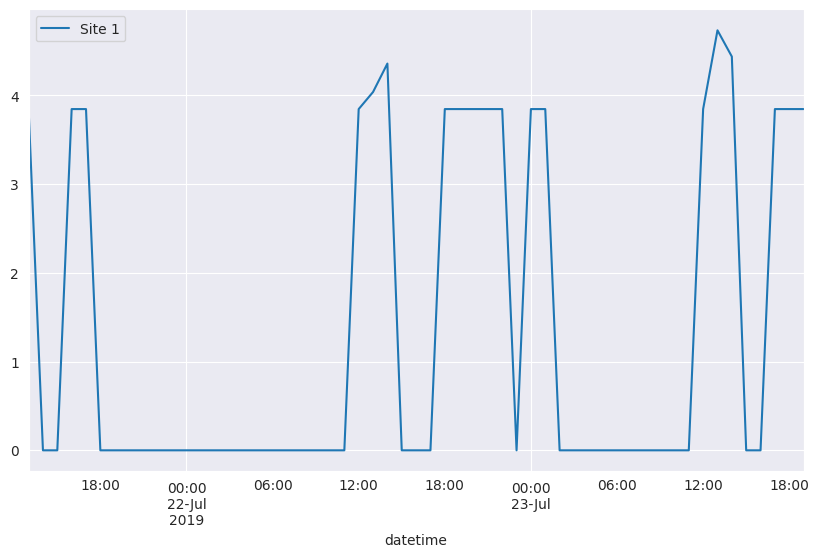

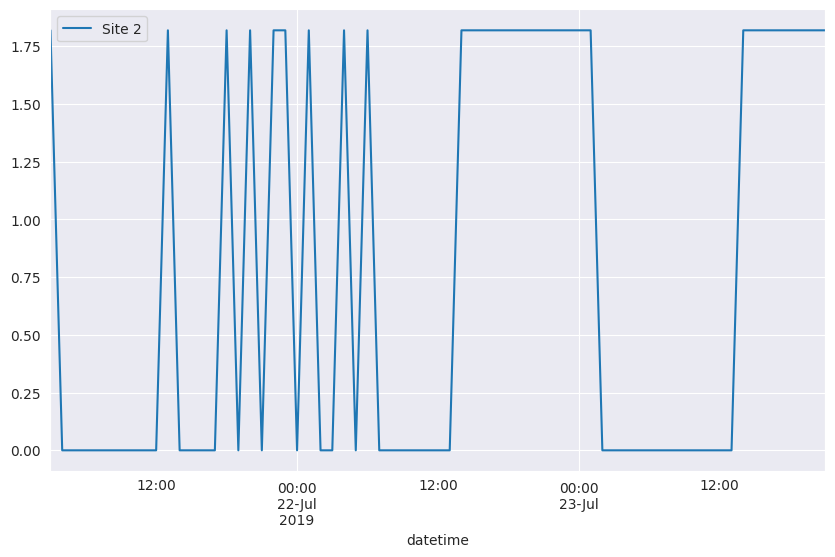

In [140]:
# Get number of stations per site
stations_per_site = df_charging.groupby('siteID')['stationID'].nunique()

# Time Interval
start_date = "2019-07-21"
end_date = "2019-07-24"

# Filter data for the specific time interval
df_filtered = df_charging[(df_charging['connectionTime'] >= start_date) & (df_charging['disconnectTime'] <= end_date)].copy()

# Expand datetime to columns
df_filtered['year'] = df_filtered['connectionTime'].dt.year
df_filtered['month'] = df_filtered['connectionTime'].dt.month
df_filtered['day'] = df_filtered['connectionTime'].dt.day
df_filtered['hour'] = df_filtered['connectionTime'].dt.hour
df_filtered['minute'] = df_filtered['connectionTime'].dt.minute

# Same for end time
df_filtered['year_end'] = df_filtered['disconnectTime'].dt.year
df_filtered['month_end'] = df_filtered['disconnectTime'].dt.month
df_filtered['day_end'] = df_filtered['disconnectTime'].dt.day
df_filtered['hour_end'] = df_filtered['disconnectTime'].dt.hour
df_filtered['minute_end'] = df_filtered['disconnectTime'].dt.minute

# Drop everything expect these columns and siteID
df_filtered = df_filtered[['siteID', 'year', 'month', 'day', 'hour', 'minute', 'year_end', 'month_end', 'day_end', 'hour_end', 'minute_end']]

# Group by year, month, day, hour, minute and siteID
df_grouped = df_filtered.groupby(['year', 'month', 'day', 'hour', 'minute', 'siteID']).size().reset_index(name='count')

# Calculate utilisation rate per minute based on the number of stations per site
df_grouped['utilisation_rate'] = (df_grouped['count'] / stations_per_site[df_grouped['siteID']].values) * 100
display(df_grouped)

# Group by siteID and hour and calculate the average utilisation rate
df_grouped_hourly = df_grouped.groupby(['siteID', 'year', 'month', 'day', 'hour'])['utilisation_rate'].mean().reset_index()
display(df_grouped_hourly)

# Combine to datetime
df_grouped_hourly['datetime'] = pd.to_datetime(df_grouped_hourly[['year', 'month', 'day', 'hour']])

# We now still have missing gaps for hours when no data is available
# We can fill these gaps with 0
df_grouped_hourly = df_grouped_hourly.set_index('datetime').groupby('siteID').apply(lambda x: x.resample('H').mean()).fillna(0).reset_index()

# Drop columns that are not needed
df_grouped_hourly = df_grouped_hourly.set_index('datetime')
df_grouped_hourly = df_grouped_hourly.sort_index()
display(df_grouped_hourly)

# Ensure is sorted by datetime
df_grouped_by_siteID = df_grouped_hourly.groupby('siteID')

# Plot the utilization rate per station and hour
for label, group in df_grouped_by_siteID:
    group.plot(y='utilisation_rate', label=f'Site {label}', figsize=(10, 6))
